In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os

from itertools import product

import pandas as pd
import numpy as np
import xarray as xr

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.colors as colors
import cmocean

import cartopy
import cartopy.crs as ccrs

import xpersist as xp
cache_dir = '/glade/p/cgd/oce/projects/cesm2-marbl/xpersist_cache/3d_fields'
if (os.path.isdir(cache_dir)):
    xp.settings['cache_dir'] = cache_dir
os.makedirs(cache_dir, exist_ok=True)

os.environ['CESMDATAROOT'] = '/glade/scratch/mclong/inputdata'
import pop_tools


import climo_utils as cu
import utils
import discrete_obs 

import plot

In [3]:
import intake
catalog = intake.open_esm_datastore('data/campaign-cesm2-cmip6-timeseries.json')
df = catalog.search(experiment='historical', component='ocn', stream='pop.h').df
variables = df.variable.unique()

In [4]:
[v for v in variables if 'Fe' in v or 'iron' in v.lower() or 'sed' in v.lower() or 'dust' in v.lower()]

['ATM_COARSE_DUST_FLUX_CPL',
 'ATM_FINE_DUST_FLUX_CPL',
 'Fe',
 'Fe_RIV_FLUX',
 'Fe_scavenge',
 'Fe_scavenge_rate',
 'Fefree',
 'IRON_FLUX',
 'Jint_100m_Fe',
 'P_iron_FLUX_100m',
 'P_iron_FLUX_IN',
 'P_iron_PROD',
 'P_iron_REMIN',
 'SEAICE_DUST_FLUX_CPL',
 'SedDenitrif',
 'bsiToSed',
 'calcToSed',
 'calcToSed_ALT_CO2',
 'diatFe',
 'diat_Fe_lim_Cweight_avg_100m',
 'diat_Fe_lim_surf',
 'diazFe',
 'diaz_Fe_lim_Cweight_avg_100m',
 'diaz_Fe_lim_surf',
 'dustToSed',
 'dust_FLUX_IN',
 'dust_REMIN',
 'pfeToSed',
 'photoFe_diat',
 'photoFe_diaz',
 'photoFe_sp',
 'pocToSed',
 'ponToSed',
 'popToSed',
 'spFe',
 'sp_Fe_lim_Cweight_avg_100m',
 'sp_Fe_lim_surf',
 'tend_zint_100m_Fe']

In [5]:
cluster, client = utils.get_ClusterClient()
cluster.scale(12) #adapt(minimum_jobs=0, maximum_jobs=24)
client

/glade/work/mclong/miniconda3/envs/cesm2-marbl/lib/python3.7/site-packages/distributed/dashboard/core.py:79: UserWarning: 
Port 8787 is already in use. 
Perhaps you already have a cluster running?
Hosting the diagnostics dashboard on a random port instead.
  warnings.warn("\n" + msg)


Client Scheduler: tcp://10.12.206.38:33917 Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/mclong/proxy/41799/status,Cluster Workers: 0 Cores: 0 Memory: 0 B


In [6]:
ds_grid = pop_tools.get_grid('POP_gx1v7')
masked_area = ds_grid.TAREA.where(ds_grid.REGION_MASK > 0).fillna(0.).expand_dims('region')
masked_area #.plot()

/glade/work/mclong/miniconda3/envs/cesm2-marbl/lib/python3.7/site-packages/numba/np/ufunc/parallel.py:365: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 6103. The TBB threading layer is disabled.
  warnings.warn(problem)


<xarray.DataArray 'TAREA' (region: 1, nlat: 384, nlon: 320)>
array([[[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [1.52530781e+13, 1.52530781e+13, 1.52530781e+13, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        ...,
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00]]])
Dimensions without coordinates: region, nlat, nlon
Attributes:
    units:        cm^2
    long_name:    area of T cells
    coordinates:  TLONG TLAT

`dust_to_Fe`: conversion of dust to iron (nmol Fe/g Dust)
```
dust remin gDust = 0.035 gFe       mol Fe     1e3 mmolFe
                    --------- *  ----------- * ----------
                      gDust      molw_Fe gFe      molFe
```                      

In [7]:
molw_Fe =  55.845
dust_to_Fe_mmol = 0.035 / molw_Fe * 1.0e3
dust_to_Fe_mmol

0.6267347121497001

In [8]:
percm2_to_perm2 = 1e4
pers_to_peryr = 86400. * 365.
nmolcm3_to_nM = 1e3
nmolcm2s_to_mmolm2yr = 1e-9 * 1e3 * 1e4 * 86400 * 365.
µmolm2d_to_mmolm2yr = 1e-3 * 365.
mmols_to_Gmolyr = 1e-12 * 86400. * 365.
nmols_to_Gmolyr = 1e-18 * 86400. * 365.

time_slice = slice("1990-01-15", "2015-01-15")
varlist = [
    'Fe',
    'IRON_FLUX',
    'Fe_RIV_FLUX',
    'pfeToSed',   
    'dust_REMIN',
]
ds_list = []
for variable in varlist:
    xp_func = xp.persist_ds(cu.read_CESM_var, name=f'{variable}', trust_cache=True)    
    ds_list.append(xp_func(
        time_slice, 
        variable, 
        mean_dims=['member_id', 'time'], 
    ))
    
ds = xr.merge(ds_list)
ds['dz'] = ds_grid.dz.drop('z_t') # drop z_t because precision issues cause diffs
ds['TAREA'] = ds_grid.TAREA

# add data from forcing files
ds = xr.merge((ds, cu.get_fesedflux_forcing(),))

# compute dust remin component 
assert ds.dust_REMIN.attrs['units'] == 'g/cm^3/s'
ds['Fe_from_dust'] = (ds.dust_REMIN * dust_to_Fe_mmol * ds.dz).sum('z_t') * percm2_to_perm2 * pers_to_peryr 
ds.Fe_from_dust.attrs['units'] = 'mmol m$^{-2}$ yr$^{-1}$'

ds['Fe_aeolian_input'] = ds.Fe_from_dust + ds.IRON_FLUX
ds.Fe_aeolian_input.attrs['units'] = 'mmol m$^{-2}$ yr$^{-1}$'

# compute global integrals
convert_glb_Gmolyr = dict(
    IRON_FLUX=mmols_to_Gmolyr * 1e-4,
    Fe_from_dust=1e-12 * 1e-4,
    pfeToSed=-1. * nmols_to_Gmolyr,
    Fe_ventflux=1e-12 * 1e-4,
    Fe_sedflux=1e-12 * 1e-4,
    Fe_RIV_FLUX=nmols_to_Gmolyr,
)
ds_glb = xr.Dataset()
for v in convert_glb_Gmolyr.keys():
    ds_glb[v] = (masked_area * ds[v]).sum(['nlat', 'nlon']) * convert_glb_Gmolyr[v]
    ds_glb[v].attrs['units'] = 'Gmol yr$^{-1}$'
    
    
global_Fe_inv = (ds.Fe * ds.TAREA * ds.dz).sum() * 1e-18
global_Fe_inv.attrs['units'] = 'Gmol'
    
# convert to nice units    
with xr.set_options(keep_attrs=True):
    
    for v in ['Fe', 'Fe_RIV_FLUX', 'pfeToSed', 'IRON_FLUX']:
        if ds[v].attrs['units'] == 'mmol/m^3':
            ds[v] = ds[v] * nmolcm3_to_nM
            ds[v].attrs['units'] = 'nM'
    
        elif ds[v].attrs['units'] in ['nmol/cm^2/s', 'mmol/m^3 cm/s']:
            ds[v] = ds[v] * nmolcm2s_to_mmolm2yr
            ds[v].attrs['units'] = 'mmol m$^{-2}$ yr$^{-1}$'        
        
        elif ds[v].attrs['units'] in ['mmol/m^2/s']:
            ds[v] = ds[v] * 86400. * 365. #* 1e4
            ds[v].attrs['units'] = 'mmol m$^{-2}$ yr$^{-1}$'        
    
           
# make dataset map-plottable
dsp = utils.pop_add_cyclic(ds)
dsp.info()

assuming cache is correct
reading cached file: /glade/p/cgd/oce/projects/cesm2-marbl/xpersist_cache/3d_fields/Fe.nc
assuming cache is correct
reading cached file: /glade/p/cgd/oce/projects/cesm2-marbl/xpersist_cache/3d_fields/IRON_FLUX.nc
assuming cache is correct
reading cached file: /glade/p/cgd/oce/projects/cesm2-marbl/xpersist_cache/3d_fields/Fe_RIV_FLUX.nc
assuming cache is correct
reading cached file: /glade/p/cgd/oce/projects/cesm2-marbl/xpersist_cache/3d_fields/pfeToSed.nc
assuming cache is correct
reading cached file: /glade/p/cgd/oce/projects/cesm2-marbl/xpersist_cache/3d_fields/dust_REMIN.nc
xarray.Dataset {
dimensions:
	nlat = 384 ;
	nlon = 321 ;
	z_t = 60 ;

variables:
	float32 z_t(z_t) ;
	float64 TLAT(nlat, nlon) ;
	float64 TLONG(nlat, nlon) ;
	float32 Fe(z_t, nlat, nlon) ;
		Fe:long_name = Dissolved Inorganic Iron ;
		Fe:units = nM ;
		Fe:grid_loc = 3111 ;
		Fe:cell_methods = time: mean ;
	float32 IRON_FLUX(nlat, nlon) ;
		IRON_FLUX:long_name = Atmospheric Iron Flux ;
		

In [9]:
df_glb = ds_glb.to_dataframe() #.sum(axis=1)
print(f'Global imbalance: {df_glb.sum(axis=1).values[0]:0.3f} Gmol/yr')
df_glb

Global imbalance: -0.032 Gmol/yr


,IRON_FLUX,Fe_from_dust,pfeToSed,Fe_ventflux,Fe_sedflux,Fe_RIV_FLUX
region,,,,,,
0,8.05681,5.566933,-38.614945,4.905846,19.681022,0.372556


In [10]:
client.close()
cluster.close()
del client
del cluster

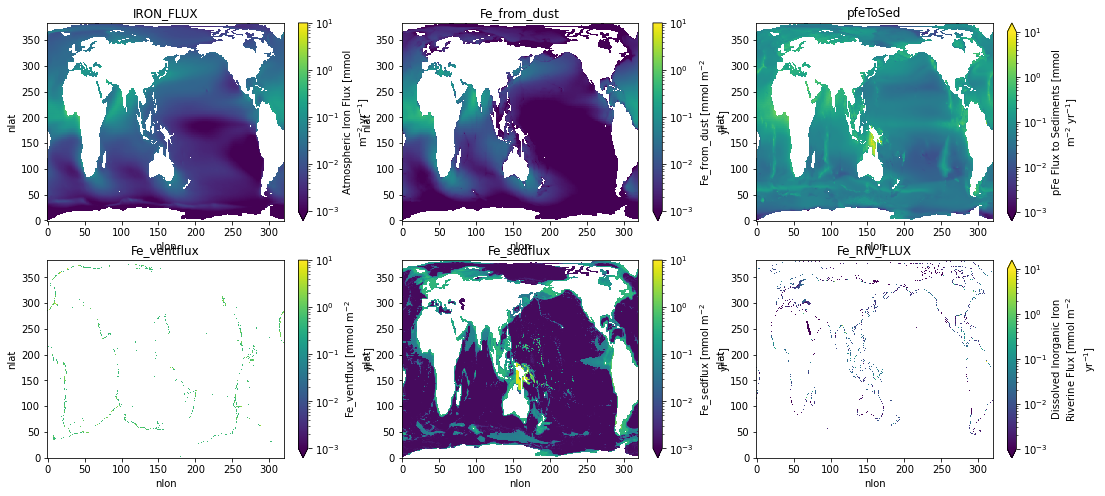

In [11]:
from matplotlib.colors import LogNorm

nvar = len(ds_glb.data_vars)
nrow = int(np.sqrt(nvar))
ncol = int(nvar/nrow) + min(1, nvar%nrow)
figsize=(6, 4)
fig, axs = plt.subplots(
    nrow, ncol, 
    figsize=(figsize[0]*ncol, figsize[1]*nrow),
    squeeze=False)

for n, v in enumerate(ds_glb.data_vars):
    i, j = np.unravel_index(n, axs.shape)
    ds[v].plot(ax=axs[i, j], norm=LogNorm(vmin=0.001, vmax=10.))
    axs[i, j].set_title(v)

In [12]:
titles = dict(
    Fe_aeolian_input=f'Aeolian deposition: {df_glb["IRON_FLUX"].values[0] + df_glb["Fe_from_dust"].values[0]:0.2f} Gmol yr$^{{-1}}$',
    Fe_sedflux=f'Sediment input: {df_glb["Fe_sedflux"].values[0]:0.2f} Gmol yr$^{{-1}}$',
    Fe_ventflux=f'Geothermal input: {df_glb["Fe_ventflux"].values[0]:0.2f} Gmol yr$^{{-1}}$',
    pfeToSed=f'Loss to sediment: {df_glb["pfeToSed"].values[0]:0.2f} Gmol yr$^{{-1}}$',
)
titles

{'Fe_aeolian_input': 'Aeolian deposition: 13.62 Gmol yr$^{-1}$',
 'Fe_sedflux': 'Sediment input: 19.68 Gmol yr$^{-1}$',
 'Fe_ventflux': 'Geothermal input: 4.91 Gmol yr$^{-1}$',
 'pfeToSed': 'Loss to sediment: -38.61 Gmol yr$^{-1}$'}

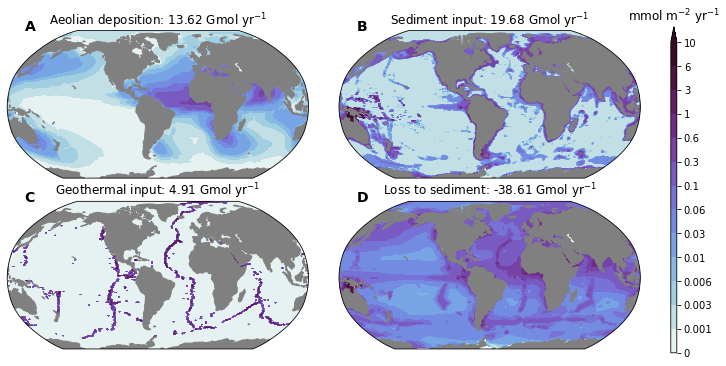

In [13]:
fields = ['Fe_aeolian_input', 'Fe_sedflux', 'Fe_ventflux', 'pfeToSed']

log_levels = [0., 0.001]
for scale in 10**np.arange(-3., 1., 1.):
    log_levels.extend(list(np.array([3., 6., 10.]) * scale))
    
levels = {k: log_levels for k in fields}


fig = plt.figure(figsize=(12, 6))
prj = ccrs.Robinson(central_longitude=305.0)

nrow, ncol = 2, 2 
gs = gridspec.GridSpec(
    nrows=nrow, ncols=ncol+1, 
    width_ratios=(1, 1, 0.02),
    wspace=0.15, 
    hspace=0.1,
)

axs = np.empty((nrow, ncol)).astype(object)
caxs= np.empty((nrow, ncol)).astype(object)
for i, j in product(range(nrow), range(ncol)):    
    axs[i, j] = plt.subplot(gs[i, j], projection=prj)
cax = plt.subplot(gs[:, -1])

cmap_field = cmocean.cm.dense


for n, field in enumerate(fields):
    
    i, j = np.unravel_index(n, axs.shape)
    
    ax = axs[i, j]
   
    cf = ax.contourf(
        dsp.TLONG,dsp.TLAT, dsp[field],
        levels=levels[field],
        extend='max',
        cmap=cmap_field,
        norm=colors.BoundaryNorm(levels[field], ncolors=cmap_field.N),
        transform=ccrs.PlateCarree(),
    )

    land = ax.add_feature(
        cartopy.feature.NaturalEarthFeature(
            'physical','land','110m',
            edgecolor='face',
            facecolor='gray'
        )
    )  
                             
    ax.set_title(titles[field]) #dsp[field].attrs['title_str'])
    
cb = plt.colorbar(cf, cax=cax, ticks=log_levels)
if 'units' in dsp[field].attrs:
    cb.ax.set_title(dsp[field].attrs['units'])
    cb.ax.set_yticklabels([f'{f:g}' for f in log_levels])
    
utils.label_plots(fig, [ax for ax in axs.ravel()], xoff=0.02, yoff=0)       
utils.savefig('iron-budget-maps.pdf')

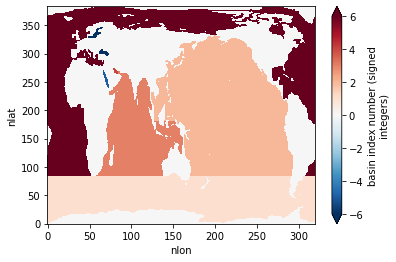

In [14]:
regions = {
    'Southern Ocean': 1,
    'Atlantic': 6, 
    'Indian': 3,
    'Pacific': 2,     
}
ds_grid.REGION_MASK.plot(vmax=6)

In [15]:
df = discrete_obs.open_datastream('dFe')
df.obs_stream.add_model_field(ds.Fe)
df.obs_stream.add_model_field(ds_grid.REGION_MASK, method='nearest')
df

,month,lon,lat,depth,don,dop,doc,Fe,REGION_MASK
0,3,-49.30228,-35.08802,11.90,3.05,0.015,NaN,0.364608,1.0
1,3,-49.30228,-35.08802,28.30,5.14,0.132,NaN,0.368277,1.0
2,3,-49.30228,-35.08802,41.70,4.19,0.120,NaN,0.373314,1.0
3,3,-49.30228,-35.08802,45.10,4.79,0.118,NaN,0.374599,1.0
4,3,-49.30228,-35.08802,49.60,3.51,NaN,NaN,0.378039,1.0
...,...,...,...,...,...,...,...,...,...
73743,0,-158.00000,22.75000,660.47,2.75,0.060,55.24,0.305747,2.0
73744,0,-158.00000,22.75000,716.11,2.62,0.050,54.26,0.287523,2.0
73745,0,-158.00000,22.75000,828.40,2.40,0.040,51.54,0.279607,2.0
73746,0,-158.00000,22.75000,938.41,2.26,0.030,48.57,0.295663,2.0


In [16]:
plt.plot(df.dFe_obs, df.Fe, '.')
plt.xlabel('CESM2 dFe [nM]')
plt.ylabel('Obs dFe [nM]')
plt.plot([0, 5], [0, 5], 'r-')

AttributeError: 'DataFrame' object has no attribute 'dFe_obs'

In [ ]:
fig, axs = plot.canvas(3, 1, figsize=(6, 2.5), use_gridspec=True, hspace=0.06)

dx = 0.05
bin_edges = np.arange(0., 1.5+dx, dx)
bins = np.vstack((bin_edges[:-1], bin_edges[1:])).mean(axis=0)

depth_ranges = {
    '–100m < z': (0., 100.),
    '-500m < z < -100 m': (100., 500.),
    '   z < -500m': (500., 1e36),
}

for n, (key, depth_range) in enumerate(depth_ranges.items()):
    ax = axs[n, 0]
    df_sub = df.loc[(depth_range[0] <= df.depth) & (df.depth <= depth_range[1])]
    
    hist, _ = np.histogram(df_sub.dFe_obs.values, bin_edges)
    ax.bar(bins, hist, width=dx, alpha=0.7, label='Obs')
    
    hist, _ = np.histogram(df_sub.Fe.values, bin_edges)
    ax.bar(bins, hist, width=dx, alpha=0.6, label='CESM2-MARBL')
    
    if n == 0:
        ax.legend(loc='upper right', frameon=False)
    if n < 2:
        ax.set_xticklabels([])
    ylm = ax.get_ylim()
    ax.text(0.75, ylm[1] - 0.12 * np.diff(ylm), key, 
            fontweight='bold',
            fontsize=12,
            ha='center',
           )
    if n == 1:
        ax.set_ylabel('Number of samples')
    if n == 2:
        ax.set_xlabel('Dissolved iron concentration [nM]')
        
utils.label_plots(fig, [ax for ax in axs.ravel()]) #, xoff=0.02, yoff=0)               
utils.savefig('iron-global-ocean-obs-PDF')

In [ ]:
residence_time = -(global_Fe_inv / ds_glb.pfeToSed).values[0]
print(f'Fe residence time: {residence_time:0.2f} yr')

In [ ]:
field = 'Fe'

levels = {'Fe': [0., 0.05, 0.1, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.6, 0.8, 1., 2.5, 5.0]}


fig = plt.figure(figsize=(10, 8))
prj = ccrs.Robinson(central_longitude=305.0)

nrow, ncol = 3, 2 
gs = gridspec.GridSpec(
    nrows=nrow, ncols=ncol+1, 
    width_ratios=(1, 1, 0.03),
    wspace=0.05, 
    hspace=0.2,
)

axs = np.empty((nrow, ncol)).astype(object)
caxs= np.empty((nrow, ncol)).astype(object)
for i, j in product(range(nrow), range(ncol)):    
    axs[i, j] = plt.subplot(gs[i, j], projection=prj)
cax = plt.subplot(gs[:, -1])

cmap_field = cmocean.cm.dense


for i, (key, depth_range) in enumerate(depth_ranges.items()):
    for j in range(2):
        ax = axs[i, j]
        if j == 0:
            zslice = slice(depth_range[0]*100., depth_range[1]*100.)

            cf = ax.contourf(
                dsp.TLONG,dsp.TLAT, dsp[field].sel(z_t=zslice).mean('z_t'),
                levels=levels[field],
                extend='max',
                cmap=cmap_field,
                norm=colors.BoundaryNorm(levels[field], ncolors=cmap_field.N),
                transform=ccrs.PlateCarree(),
            )
        else:
            df_sub = df.loc[(depth_range[0] <= df.depth) & (df.depth <= depth_range[1])]
            sc = ax.scatter(
                df_sub.lon, df_sub.lat, c=df_sub.dFe_obs.values,
                cmap=cmap_field,
                norm=colors.BoundaryNorm(levels[field], ncolors=cmap_field.N),
                s=6,
                transform=ccrs.PlateCarree(),
            )

        land = ax.add_feature(
            cartopy.feature.NaturalEarthFeature(
                'physical','land','110m',
                edgecolor='face',
                facecolor='gray'
            )
        )  

cb = plt.colorbar(cf, cax=cax, ticks=levels['Fe'])
if 'units' in dsp[field].attrs:
    cb.ax.set_title(dsp[field].attrs['units'])
    cb.ax.set_yticklabels([f'{f:g}' for f in levels['Fe']])

utils.subplot_col_labels(axs[0, :], ['CESM2', 'Observations'])    
utils.subplot_row_labels(axs[:, 0], depth_ranges.keys(), xoff=60)
    
utils.label_plots(fig, [ax for ax in axs.ravel()], xoff=0.02, yoff=0)       
utils.savefig('iron-concentration-maps.pdf')